# Neural Style Transfer (NST)

The process of NST assumes an input image p and an example style image a.
The image p is fed through a pretrained CNN, and network activations are sampled at a late convolution layer of the CNN architecture (original paper used VGG-19). Let C(p) be the resulting output sample, called the 'content' of the input p.
The style image a is then fed through the same CNN, and network activations are sampled at the early to middle layers of the CNN. These activations are encoded into a Gramian matrix representation, call it S(a) to denote the 'style' of a.
The goal of NST is to synthesize an output image x that exhibits the content of p applied with the style of a, i.e. C(x)=C(p) and S(x)=S(a).
An iterative optimization (usually gradient descent) then gradually updates x to minimize the loss function error:
L(x)=∣C(x)−C(p)∣+k∣S(x)−S(a)∣, where ∣⋅∣ is the L2 distance. The constant k controls the level of the stylization effect. 

Note: text copied from Wikipedia

c:\Users\s_gue\anaconda3\envs\ml_basics\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


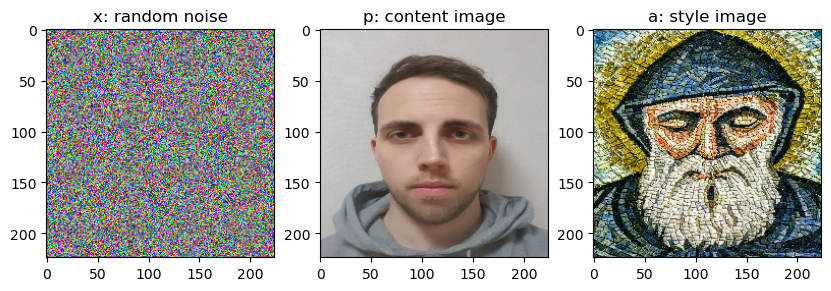

In [1]:
import numpy as numpy
import matplotlib.pyplot as plt
import torch
import torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x = torch.rand(3, 224, 224).to(device) 
x.requires_grad = True # to optimize it with GD
p = torchvision.io.read_image(path = "./files/profile_pic.jpg").to(device).type(torch.float32)/255.0
a = torchvision.io.read_image(path = "./files/mosaic_style.jpg").to(device).type(torch.float32)/255.0

#resize images to fit expected VGG dimensions
p = torchvision.transforms.functional.resize(img = p, size = [224, 224], interpolation = torchvision.transforms.InterpolationMode.BILINEAR)
a = torchvision.transforms.functional.resize(img = a, size = [224, 224], interpolation = torchvision.transforms.InterpolationMode.BILINEAR)

#show both images next to each other:
plt.figure(figsize = (10, 10))
plt.subplot(1, 3, 1)
plt.title("x: random noise")
plt.imshow(x.permute(1, 2, 0).cpu().detach().numpy())
plt.subplot(1, 3, 2)
plt.title("p: content image")
plt.imshow(p.permute(1, 2, 0).cpu().detach().numpy())
plt.subplot(1, 3, 3)
plt.title("a: style image")
plt.imshow(a.permute(1, 2, 0).cpu().detach().numpy())

The dataset does not need to return the content and style image as they never change. Better put them into the model

In [19]:
f = torch.rand(1, 3, 224, 224).to(device) #random noise
g = torch.rand(1, 3, 224, 224).to(device) #random noise
loss = nn.MSELoss()
loss(f, g)

AttributeError: 'list' object has no attribute 'size'

In [13]:
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import pytorch_lightning as pl
import torchvision.models as models
from typing import List

# Create a callable for the hooks
class Get_Layer_Output:
 def __init__(self):
    self.outputs = []

 def __call__(self, module, module_in, module_out):
    self.outputs.append(module_out)

 def clear(self):
    self.outputs = []


class NST_Loss(nn.Module):
    def __init__(self, p, p_layers: List):
        super().__init__()

        # Load the pretrained VGG19 model
        self.vgg19 = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
        self.vgg19.eval() # freeze the model
        self.vgg19.to(device) # move the model to GPU

        for param in self.vgg19.features.parameters():
            param.requires_grad = False

        #Normalization and extra dim for VGG19
        self.transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        p = self.transform(p)[None,...]

        # Add hooks to the model to extract layer outputs
        self.get_layer_output_p = Get_Layer_Output()
        hook_handles = []
        for layer in self.vgg19.features.children():
            if not p_layers:
                break  # Stop iterating once all specified layers are found
            if isinstance(layer, torch.nn.modules.conv.Conv2d):
                if layer == self.vgg19.features[p_layers[0]]:
                    handle = layer.register_forward_hook(self.get_layer_output_p)
                    hook_handles.append(handle)
                    p_layers.pop(0)
        
        self.vgg19(p)
        self.p_features = self.get_layer_output_p.outputs 
        self.num_p_layers = len(self.p_features)

    def forward(self, x: Tensor) -> Tensor:
        #Get x features
        self.get_layer_output_p.clear()
        x = self.transform(x)[None,...]
        model_out = self.vgg19(x)
        return sum([(self.p_features[i] - self.get_layer_output_p.outputs[i]).pow(2).mean()*(1/self.num_p_layers) for i in range(self.num_p_layers)])

        #At this point self.get_layer_output_p.outputs contains the outputs of the layers for x
        #We now need to calculate the MSE between the two lists (self.p_features and self.get_layer_output_p.outputs)
        #return F.mse_loss(input, target, reduction=self.reduction)
    
class NST_model(pl.LightningModule):
    def __init__(self, x, p, a):
        super().__init__()
        self.x = nn.Parameter(x.clone()) #nn.Parameter specifies that this is an updateable parameter
        self.NST_loss = NST_Loss(p, p_layers = [2,5])
        
    def forward(self):
        return self.x
    
    def training_step(self, batch, batch_idx):
        loss = self.NST_loss(self.x)
        print(loss)
        plt.imshow(self.x.permute(1, 2, 0).cpu().detach().numpy())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)

# We set the updateable parameters of the model to be the random input image x
# We are comparing x with the content image p instead of an input. Bc Pytorch expects an input, 
# we need to create a dummy loader (that loads no input, but only uses p as the target)   
class NST_dataset(Dataset):
    def __init__(self):
        pass
    def __len__(self):
        return 1
    def __getitem__(self, idx):
        return 0

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type     | Params
------------------------------------------
0 | NST_loss     | NST_Loss | 143 M 
  | other params | n/a      | 150 K 
------------------------------------------
123 M     Trainable params
20.0 M    Non-trainable params
143 M     Total params
575.271   Total estimated model params size (MB)


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(11.8499, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(10.8986, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(10.0195, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(9.2091, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(8.4640, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(7.7807, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(7.1558, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(6.5852, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(6.0650, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]       

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(5.5915, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(5.1607, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(4.7684, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(4.4114, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(4.0862, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(3.7899, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(3.5198, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(3.2734, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(3.0486, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2.8429, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2.6545, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2.4820, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2.3239, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2.1785, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2.0446, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.9211, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.8072, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.7019, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.6045, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.5142, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.4304, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.3524, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.2796, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.2118, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.1483, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.0890, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.0335, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.9816, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.9332, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.8878, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.8453, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.8057, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.7685, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.7337, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.7013, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6708, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6423, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6156, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.5907, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=26]        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.5675, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s, v_num=26]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:01<00:00,  0.57it/s, v_num=26]


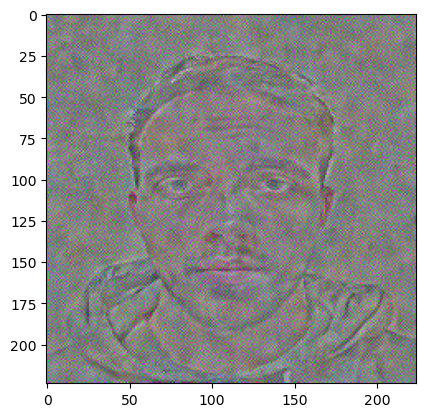

In [15]:
model = NST_model(x, p, a)
dataset = NST_dataset()
trainer = pl.Trainer(max_epochs=50)
dataloader = DataLoader(dataset, batch_size=1)
trainer.fit(model, dataloader)

The original paper used VGG19 to extract content and style features as follows: 
"The images [...] were synthesised by matching the content representation on layer ‘conv4_2’ 
and the style representation on layers‘conv1_1’, ‘conv2_1’, ‘conv3_1’, ‘conv4_1’ and ‘conv5_1’
(wl = 1/5 in those layers, wl = 0 in all other layers)."

L. A. Gatys, A. S. Ecker and M. Bethge, "Image Style Transfer Using Convolutional Neural Networks," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, 2016, pp. 2414-2423, doi: 10.1109/CVPR.2016.265.

--> Early layers tend to capture gradients and textures, while later layers tend towards more complex types of feature.

In [ ]:
import torchvision.models as models

# Load the pretrained VGG19 model
vgg19 = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
vgg19.eval() # freeze the model
vgg19.to(device) # move the model to GPU

#Let's have a look at the model architecture
vgg19

We need to get the model's output at different layers. The most efficient way is to use a forward hook and store the layers in a list.

In [10]:
# Create a callable for the hooks
class Get_Layer_Output:
 def __init__(self):
    self.outputs = []

 def __call__(self, module, module_in, module_out):
    self.outputs.append(module_out)

 def clear(self):
    self.outputs = []

get_layer_output = Get_Layer_Output()
hook_handles = []

layer_ids = [2, 5]
for layer in vgg19.features.children():
    if not layer_ids:
        break  # Stop iterating once all specified layers are found
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        if layer == vgg19.features[layer_ids[0]]:
            handle = layer.register_forward_hook(get_layer_output)
            hook_handles.append(handle)
            layer_ids.pop(0)

# Forward pass with your input data
# Assuming your input data is stored in the variable input_data
out = vgg19(p[None,...])

VGG19 expects normalized values + we need to add a batch dimension

In [ ]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
p = normalize(p)
p = p[None,...]

Note to myself: we need to clean the hook after every call cause it keeps appending

In [13]:
get_layer_output.outputs[1].shape

IndexError: list index out of range

In [12]:
get_layer_output.clear()